# Explainer Notebook Final Project Part B #

This is the accompanying notebook for the final project of the Social Data visualization course.

Here we explain the different aspects of the project in more technical detail.

# Motivation #

In this project, we are working with houseingprices from copenhagen. We chose this because soon both of us will (hopefully) enter the copenhagen housing market, and having grown up in times of financial uncertainty, we feel like taking a good look at the current as well as historical development of the housing market 

The goal of this project is to tell the story of the copenhagen housing market from 2000-2024, and analyse key events that are believed to have had an impact on this. Unfortunately there is not a good source of data for this which is easily accessible. Therefore we have chosen to scrape a dataset ourselves from the website "boligsiden.dk". 

# Scraping # 

The scraping is done using beautiful soup, a good library for navigating HTML code in python. 
One quirk about boligsiden is that they can only show 500 pages of a single search query, so when we scrape we need to ensure that our queries will give less pages than 500. we do this by creating combinations of area, years and municipality, e.g. one query will be sales in copenhagen, between 2000-2001, with area between 60-61 m2. 

For each sale we log the variables: longitude, latitude, neighbourhood, date and areaprice. the script is shown below: 



In [ ]:
import os
import requests
import pandas as pd
from bs4 import BeautifulSoup
import json
import re
from tqdm import tqdm
import time
import random
# year intervals
years = [2000+i for i in range(25)]
yearIntervals = [(years[i],years[i+1]) for i in range(24)]
# list of areas
areas = [[i,i+1] for i in range(300)]
areas[-1][1] = 10000

df_dict = {}
for kommune in ['koebenhavn','frederiksberg']:
    for years in yearIntervals:
        if not os.path.isfile(f'{str(years[0])}_kbh_scrape.xlsx'):
            obs_list = []
            print(f'Currently scraping from {years[0]} to {years[1]}')
            for area in areas:
                print(f'area range: {area}')
                page = 1
                full_page = True
                while full_page:
                    url = fr'https://www.boligsiden.dk/kommune/{kommune}/solgte?sortAscending=false&yearSoldFrom={years[0]}&yearSoldTo={years[1]}&areaMin={area[0]}&areaMax={area[1]}&page={page}'
                    response = requests.get(url)
                    if response.status_code == 200:
                        raw_html = response.text
                        soup = BeautifulSoup(raw_html, 'html.parser')

                        page_labels = soup.find_all('a', {'aria-label': True})
                        script_tag = soup.find('script', {'id': '__NEXT_DATA__'})
                        json_data = script_tag.string
                        data = json.loads(json_data)
                        normjson = pd.json_normalize(data['props']['pageProps']['searchResults']['sold'])
                        if len(normjson) == 0:
                            full_page = False
                        else:
                            for b_id in range(len(normjson['registrations'])):
                                lat = normjson['coordinates.lat'][b_id]
                                lon = normjson['coordinates.lon'][b_id]
                                bydel = normjson['cityName'][b_id]
                                for s_id in range(len(normjson['registrations'][b_id])):
                                    date = normjson['registrations'][b_id][s_id]['date']
                                    pap = normjson['registrations'][b_id][s_id]['perAreaPrice']
                                    price = normjson['registrations'][b_id][s_id]['amount']
                                    obs_list.append([lat,lon,bydel,date,pap])
                    page += 1
            # save after each year to allow for stopping and starting the scrape
            df_dict[str(years[0])] = pd.DataFrame(obs_list) 
            df_dict[str(years[0])].to_excel(f'{str(years[0])}_kbh_scrape.xlsx')
        else:
            print(f'year {years} was already scraped')
    
                                

# Basic stats #

A number of things must be done to the data before we can use it for analysis and visualization. 
First and foremost, there are a lot of outliers that heavily influence the data as is.
After inspecting the distribution we decide to remove the observations within top 3% of areaprice.
Furthermore we remove the neighbourhoods 'Hellerup','Kastrup','Rødovre', as we intend to produce cloropleth maps, and we do not have the shapefiles for these areas.



In [28]:

import pandas as pd
import numpy as np

# collect all saved files from scraping
File_names = ['frederiksberg_scrape.xlsx'] + [f'{i}_kbh_scrape.xlsx' for i in range(2000,2024)]
df_list = []
for filename in File_names:
    df = pd.read_excel(filename)
    df = df.drop('Unnamed: 0',axis = 1)
    df.columns = ['lon','lat','bydel','date','areaprice']
    if filename == 'frederiksberg_scrape.xlsx':
        df['bydel'] = ['Frederiksberg']*len(df)
    df['date'] = pd.to_datetime(df['date'])
    df = df[df.areaprice < df.areaprice.quantile(.97)]
    df = df[df['date'] >= pd.to_datetime('01/01/2000') ]
    df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
    df['ones'] = np.ones(len(df))
    df_list.append(df)

# merge into one large data frame
big_df = pd.concat(df_list)
Bydele = list(set(big_df['bydel']))
Bydele.remove('Hellerup')
Bydele.remove('Kastrup')
Bydele.remove('Rødovre') 

Below we can see the distribution of the sqm. price in the different neighbourhoods, when removin the top 3% observations. 

Text(0, 0.5, 'Square meter price in DKK')

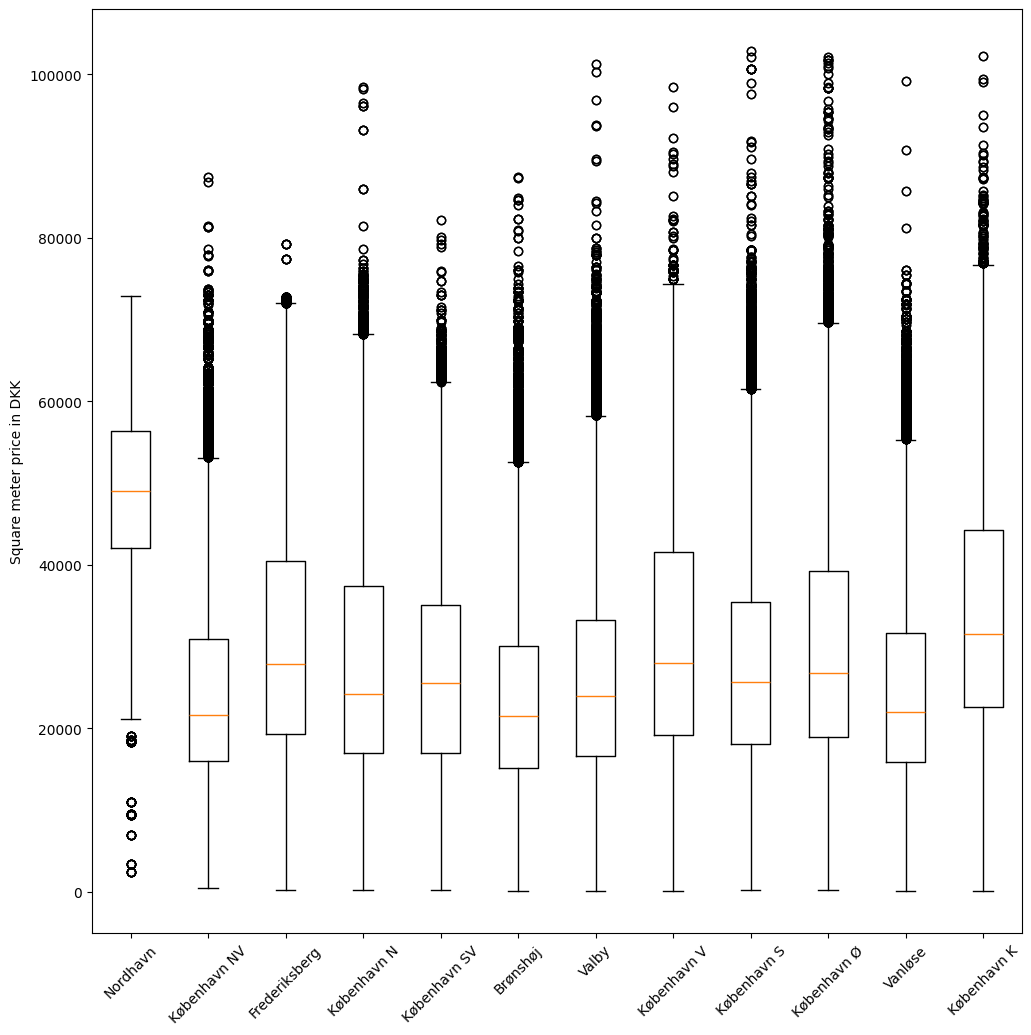

In [35]:
import matplotlib.pyplot as plt
Data = [big_df[big_df['bydel'] == bydel]['areaprice'] for bydel in Bydele]
fig,ax = plt.subplots(figsize = (12,12))
plt.boxplot(Data)
ax.set_xticklabels(Bydele,rotation = 45)
ax.set_ylabel('Square meter price in DKK')

# Analysis #
 We now have a very large list of recorded sales (2889191 observations), which is then aggregated based on neighbourhood and quarters. 
 That is, for each neighbourhood and quarter between 2000Q1-2024Q1, we calculate the average areaprice,and count the number of sales. 
 We are also interested in looking at the average across all neighbourhoods. 

In [29]:
Num_Dict = { }
Price_Dict = { }
for ind, bydel in enumerate(Bydele):        
    df = big_df[big_df['bydel'] == bydel]
    Price_Dict[bydel] = df.groupby([df['quarter']])['areaprice'].mean()
    Num_Dict[bydel] = df.groupby([df['quarter']])['ones'].sum()

df_Num = pd.DataFrame(Num_Dict)
df_Num['Quarter'] = df_Num.index
df_Num['Total'] = df_Num[Bydele].sum(axis = 1)

df_Price = pd.DataFrame(Price_Dict)
df_Price['Quarter'] = df_Price.index
df_Price['Total'] = df_Price[Bydele].mean(axis = 1)


# remove 2024Q2 as it is not complete as of april 2024
df_Price = df_Price.drop('2024Q2')
df_Num = df_Num.drop('2024Q2')

To further analyse the square meter price over time, we calculate the relative difference from one quarter to the next

In [3]:
# Create relative growth from quarter to quarter
RelDiff = df_Price['Total'][1:].values / df_Price['Total'][:-1].values -1
RelDiff = pd.DataFrame(RelDiff,index = df_Price.index[1:])
RelDiff_pos = RelDiff[RelDiff[0]>0]

pos_ind = [i for i in range(len(RelDiff)) if RelDiff[0][i]>0]

RelDiff_neg = RelDiff[RelDiff[0]<0]
neg_ind = [i for i in range(len(RelDiff)) if RelDiff[0][i]<0]

Index(['Nordhavn', 'København NV', 'Frederiksberg', 'København N',
       'København SV', 'Brønshøj', 'Valby', 'København V', 'København S',
       'København Ø', 'Vanløse', 'København K', 'Quarter', 'Total'],
      dtype='object')

# Visualizations #

## Lineplots ##
We make two lineplots as a preliminary analysis of the house market in Denmark. To do this we make an interactive plot of the sales and prices over time. It is interactive so that it is easier to compare different areas of Copenhagen. Furthermore, we make a barchart to see the development in relative prices over time, that is, we make a plot looking at a quarters average price compared to the quarter before.

In [ ]:

# line plot with number of sales for each neighbourhood 
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, Legend
import seaborn as sns
from datetime import date
from bokeh.io import output_file
import matplotlib.dates as mdates
import datetime
output_file("NumSales.html")
custom_palette = sns.color_palette("Paired", 12).as_hex()


source = ColumnDataSource(df_Num)
# Create a Bokeh figure
p = figure(title="Number of Sales", x_axis_label='Time', y_axis_label='Number of Sales', x_axis_type='datetime',height = 400,width = 750)
for i,bydel in enumerate(Bydele):
# Plot neighbourhoods data
    p.line(x='Quarter', y=bydel, source=source, line_width=2,alpha = 0.7, legend_label=bydel, color=custom_palette[i])

p.line(x='Quarter', y='Total', source=source, line_width=3,alpha = 1, legend_label='Total', color='black')

annotations = ["Financial Crisis (Roskilde Bank bankruptcy)  ", "Covid-19 shutdown  ","Invasion Of Ukraine  "]
specific_dates = [date(2008, 8, 10), date(2020, 3, 13), date(2022,2,24)]  # Example specific dates
y_offsets = [50000,45000,50000]
for date_val, annotation, y_offset in zip(specific_dates, annotations, y_offsets):
    p.segment(x0=date_val, y0=0, x1=date_val, y1=50000, color="black", line_width=2,line_dash='dashed',alpha = 0.6)
    p.text(x=date_val,y=y_offset, text=[annotation], text_font_size="6pt", text_align="right", text_baseline="middle", text_color="black")


# Customize the x-axis date formatting to display only the quarter and year
p.xaxis.formatter = DatetimeTickFormatter(months=["%b %Y"])
leg = p.legend[0]
p.add_layout(leg,'right')
# Set legend click policy to 'hide'
p.legend.click_policy = 'hide'

# Show the plot
show(p)


In [ ]:
# line plot with average areaprice for each neighbourhood 

import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, Legend,HoverTool
import seaborn as sns
from bokeh.io import output_file
output_file("AvgPrice.html")


custom_palette = sns.color_palette("Paired", 12).as_hex()
# Print the list of colors
source = ColumnDataSource(df_Price)
# Create a Bokeh figure
p = figure(title="Average m2 price", x_axis_label='Time', y_axis_label='Average m2 price', x_axis_type='datetime',height = 400,width = 750)
for i,bydel in enumerate(Bydele):
# Plot data for region1 by default
    line_region1 = p.line(x='Quarter', y=bydel, source=source, line_width=1,alpha = 0.6, legend_label=bydel, color=custom_palette[i])
p.line(x='Quarter', y='Total', source=source, line_width=4,alpha = 1, legend_label='Total', color='black')


# Customize the x-axis date formatting to display only the quarter and year
p.xaxis.formatter = DatetimeTickFormatter(months=["%b %Y"])
annotations = ["Financial Crisis (Roskilde Bank bankruptcy)  ", "Covid-19 shutdown  ","Invasion Of Ukraine  "]
specific_dates = [date(2008, 8, 10), date(2020, 3, 13), date(2022,2,24)]  # Example specific dates
y_offsets = [60000,65000,70000]
for date_val, annotation, y_offset in zip(specific_dates, annotations, y_offsets):
    p.segment(x0=date_val, y0=0, x1=date_val, y1=70000, color="black", line_width=2,line_dash='dashed',alpha = 0.6)
    p.text(x=date_val,y=y_offset, text=[annotation], text_font_size="6pt", text_align="right", text_baseline="middle", text_color="black")

# Create a legend
leg = p.legend[0]
p.add_layout(leg,'right')

# Add the legend to the plot

# Set legend click policy to 'hide'
p.legend.click_policy = 'hide'

# Show the plot
show(p)


C:\Users\alboa\AppData\Local\Temp\ipykernel_39948\2061902245.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pos_ind = [i for i in range(len(RelDiff)) if RelDiff[0][i]>0]
C:\Users\alboa\AppData\Local\Temp\ipykernel_39948\2061902245.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  neg_ind = [i for i in range(len(RelDiff)) if RelDiff[0][i]<0]


Text(0, 0.5, 'Percent growth from previous quarter')

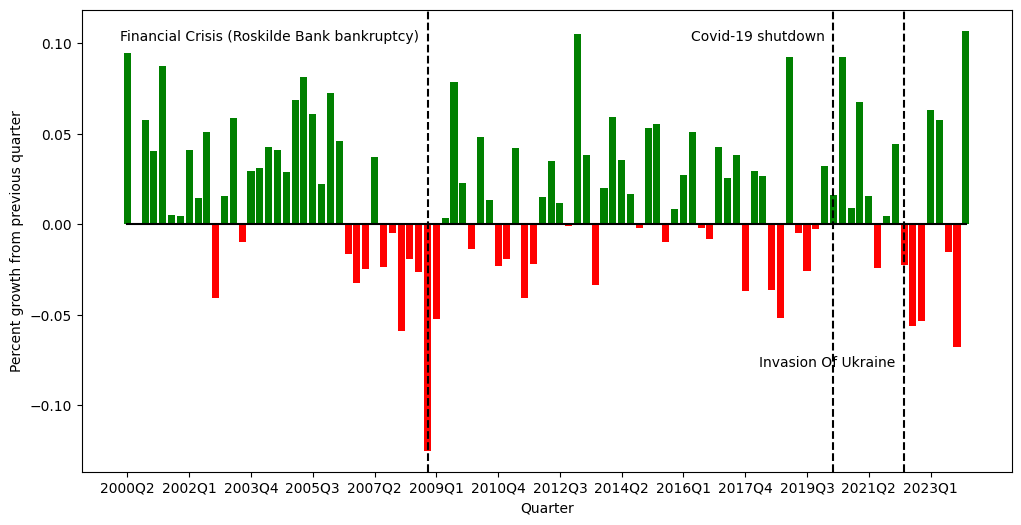

In [7]:
#Relative area price growth compared to the quarter before
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig,ax = plt.subplots(figsize = (12,6))
ax.bar(x = pos_ind,height = RelDiff_pos[0].values,color = 'green')
ax.bar(x = neg_ind,height = RelDiff_neg[0].values,color = 'red')
ax.set_xticks(ticks = [i for i in range(len(RelDiff))][::7], labels = df_Price.index[1::7])
ax.set_xlabel('Quarter')
ax.plot(pos_ind,[0]*len(pos_ind),color = 'black')

specific_dates = [date(2009, 1, 1), date(2009, 4, 1)]  # Example specific dates*
specific_points = [mdates.date2num(date_val) for date_val in specific_dates]  # Convert dates to indices

# Adding vertical lines at specific dates
annotations = ["Financial Crisis (Roskilde Bank bankruptcy)  ", "Covid-19 shutdown  ","Invasion Of Ukraine  "]
ys = [0.1,0.1,-0.08]
for point, annotation,y in zip([8*4+2, 20*4, 22*4], annotations,ys):
    ax.axvline(x=point, color='black', linestyle='--')
    ax.annotate(text=annotation, xy=(point, y), xytext=(0, 0), textcoords='offset points', ha='right', va='bottom')

ax.set_ylabel('Percent growth from previous quarter')

## Animated Maps ## 
In this part of the visualization we make three map plots - First we plot the square meter sales price as a density heatmap. This is a heatmap that combines the density of the number of sales and the square meter price. Hereby, 'brighter' areas will be either a consequence of higher sales prices or multiple sales grouped together. The plots are shown over time

In [8]:
df = pd.read_csv("Alting.csv", index_col= "Unnamed: 0")
center =  [np.mean(df['lon']), np.mean(df['lat'])]
df['date'] = pd.to_datetime(df['date'])
df['quarter'] = df['date'].dt.to_period('Q').astype(str)


In [9]:
import pandas as pd
import plotly.express as px
center =  [np.mean(df['lon']), np.mean(df['lat'])]
fig = px.density_mapbox(df.sort_values('date'), 
                        lat='lon', lon='lat', 
                        z='areaprice', 
                        radius=3,
                        center=dict(lat=center[0], lon=center[1]), 
                        zoom=10, 
                        animation_frame= 'quarter', 
                        animation_group='quarter',
                        mapbox_style="carto-positron", 
                        range_color=(min(df['areaprice']),max(df['areaprice'])), 
                        title = "Density/Price heatmap of sales")
fig.update_layout(width = 500, height = 700)
fig.update_traces(zmax=max(df['areaprice']), selector=dict(type='densitymapbox'))
fig.update_traces(zmin=min(df['areaprice']), selector=dict(type='densitymapbox'))
fig.data[0].update(zmin=min(df['areaprice']), zmax=max(df['areaprice']))    
fig.write_html("Heat_scatter_Map.html")

This second map is just a scatter of the sales with its corresponding square meter price displayed using a colorscale. 

In [10]:
import pandas as pd
import plotly.express as px
fig = px.scatter_mapbox(df.sort_values('date'), 
                        lat='lon', lon='lat', 
                        color='areaprice', 
                        center=dict(lat=center[0], lon=center[1]), 
                        zoom=10, 
                        animation_frame= 'quarter', 
                        animation_group='quarter',
                        mapbox_style="open-street-map", 
                        range_color=(min(df['areaprice']),max(df['areaprice'])), 
                        title = "Scatter of Price pr Square Meter of sales", 
                        opacity=0.2)
fig.update_layout(width = 500, height = 700)
fig.write_html("Scatter_map.html")

The following two maps are Choropleth plots of the average square meter price of the different city districts shown over time in groups of quarters. Compared to the other two maps this makes it easier to understand the price development of the different districts. One plot is before 2009 and the second is after. This is done to be able to compare the prices before and after the crash in 2007/2008 but also because the plots didn't show when made on the whole period. 

In [11]:
import geopandas as gpd
map_df = gpd.read_file('SIMONSUTTER.shx')
big_df = pd.read_csv("Alting.csv", index_col= "Unnamed: 0")
big_df['bydel']= big_df['bydel'].str.replace('Nordhavn', 'København Ø')

big_df['bydel'].unique()
Bydele = list(set(big_df['bydel']))
Bydele.remove('Hellerup')
Bydele.remove('Kastrup')
Bydele.remove('Rødovre') 
Bydele

Num_Dict = { }
Price_Dict = { }
for ind, bydel in enumerate(Bydele):        
    df = big_df[big_df['bydel'] == bydel]
    Num_Dict[bydel] = df.groupby([df['quarter']])['areaprice'].mean()
    Price_Dict[bydel] = df.groupby([df['quarter']])['ones'].sum()


df_Num = pd.DataFrame(Num_Dict)
df_Num['Quarter'] = df_Num.index
df_Num['Total'] = df_Num[Bydele].mean(axis = 1)

df_Price = pd.DataFrame(Price_Dict)
df_Price['Quarter'] = df_Price.index
df_Price['Total'] = df_Price[Bydele].mean(axis = 1)

In [18]:
df_Num

,København NV,Frederiksberg,København N,København SV,Brønshøj,Valby,København V,København S,København Ø,Vanløse,København K,Quarter,Total
quarter,,,,,,,,,,,,,
2000Q1,10448.555616,12928.788056,11158.869839,8926.897674,10839.836782,11468.529434,11058.370000,10331.885236,11530.504532,10295.963526,14552.039494,2000Q1,11230.930926
2000Q2,11345.118693,13119.288762,11904.950060,9332.761290,11547.320568,11774.439896,13397.438495,11499.555731,12529.000626,11890.971548,16897.649596,2000Q2,12294.408660
2000Q3,11381.032210,13467.736120,12489.113951,9347.364415,11341.140113,11635.326717,12400.205847,11610.555291,13612.531061,11521.216298,16571.051519,2000Q3,12307.024867
2000Q4,11710.396401,14435.427232,13159.197951,10729.186879,11335.386836,12779.876534,14692.851251,12006.886222,14447.489504,11615.734573,16305.836639,2000Q4,13019.842729
2001Q1,12656.239121,14678.765399,13349.915284,10391.748555,12783.974144,12629.208834,15789.252846,12625.672502,15757.432710,11477.550903,16918.654938,2001Q1,13550.765021
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023Q2,38839.155459,49918.325237,48661.256048,46347.454327,38989.175973,42007.663765,51251.537249,42023.126767,49038.490029,40665.091483,52001.968610,2023Q2,45431.204086
2023Q3,37048.064474,48610.178529,44257.456349,45712.306748,36841.042254,42278.150511,54097.261920,42583.325833,48454.093081,38694.983813,51238.443023,2023Q3,44528.664231
2023Q4,38031.704449,46091.016398,46952.207982,37738.723823,38890.952314,39344.505491,45268.732026,42479.503298,44346.234043,36638.855372,45047.805970,2023Q4,41893.658288


In [27]:
Bydele

['København NV',
 'Frederiksberg',
 'København N',
 'København SV',
 'Brønshøj',
 'Valby',
 'København V',
 'København S',
 'København Ø',
 'Vanløse',
 'København K']

In [19]:

geometry_dict = {Bydele[i]: [map_df.iloc[i]['ogc_fid'], map_df.iloc[i]['geometry']] for i in range(0, len(map_df))}
df_map = pd.DataFrame(columns= ['navn', "kvmpris", "ogc_fid", 'geometry', 'Quarter'])
navne = df_Price.columns[:-2]

print(navne)
index = 0
for i,name in enumerate(df_Num.iloc):
    for l,j in enumerate(name):
        if l >= 11:
            continue
        
        df_map.loc[index] = [navne[l], j, geometry_dict[navne[l]][0], geometry_dict[navne[l]][1], name.Quarter]  
        index+= 1
        
map1 = df_map.loc[:36*11-1] #Before 2009
map2 = df_map.loc[36*11:1077-11*4] #After 2009
map_df.index += 1


Index(['København NV', 'Frederiksberg', 'København N', 'København SV',
       'Brønshøj', 'Valby', 'København V', 'København S', 'København Ø',
       'Vanløse', 'København K'],
      dtype='object')


In [26]:
#Before 2009
fig = px.choropleth_mapbox(map1,
                   geojson=map_df.geometry,
                   color="kvmpris",
                   locations= "ogc_fid",
                   mapbox_style="carto-positron",
                    zoom=11, 
                    opacity= 0.5,
                    center = {"lat": 55.682283386295765, "lon": 12.527551719020813},
                   range_color = (0, max(map1['kvmpris'])),
                   animation_frame= 'Quarter', 
                   animation_group='Quarter',
                   title= "Choropleth Price Change Before 2009")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width = 500, height = 700)
fig.write_html("Pre2009_map_ny.html")

In [25]:
#after 2009
fig = px.choropleth_mapbox(map2,
                   geojson=map_df.geometry,
                   color="kvmpris",
                   locations= "ogc_fid",
                   mapbox_style="carto-positron",
                    zoom=11, 
                    opacity= 0.5,
                    center = {"lat": 55.682283386295765, "lon": 12.527551719020813},
                   range_color = (0, max(map2['kvmpris'])),
                   animation_frame= 'Quarter', 
                   animation_group='Quarter',
                   title= "Choropleth Price Change Before 2009")
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(width = 500, height = 700)
fig.write_html("POST2009_map_ny.html")

In [22]:
#After 2009
fig = px.scatter_mapbox(df.sort_values('date'), 
                        lat='lon', lon='lat', 
                        color='areaprice', 
                        center=dict(lat=center[0], lon=center[1]), 
                        zoom=10, 
                        animation_frame= 'quarter', 
                        animation_group='quarter',
                        mapbox_style="open-street-map", 
                        range_color=(min(df['areaprice']),max(df['areaprice'])), 
                        title = "Scatter of Price pr Square Meter of sales", 
                        opacity=0.2)
fig.update_layout(width = 500, height = 700)
fig.write_html("Post2009_map.html")

# Genre #
Overall the genre is a mix of magazine style, annotated graph/map and animation. 
## visual narative ##

In this project we have produced two main categories of visualization, the first being the lineplots of sqm. price/number of sales over time:
for these we employed a consistent visual platform, meaning that the visual layout, colorscheme and time axis was consistent for both of them. Also, we highlight the three events (2008 economic crisis, Covid-19 and Ukraine invasion) on both of the plots, as well as on the relative growth barchart. 


For the animated maps, we employ a interactive progress/timebar which allows the user to view any frame (quarter) at will, or simply let the movie run. Also, zooming is allowed, such that the user can focus on different areas of the map. 

## Narrative structure ##
Overall the structure of the webpage is linear, as it is ment to be read from top to bottom, and the text guides the user from one visualization to the next. 


For the lineplots and the barchart we use annotations to highlight the three events in question. The lineplots have interactive legends, which can show or hide the different neighbourhoods, 

For the animated maps, one can hover over the different objects (density, point or neighbourhood) to get an accurate number, instead of relying on the colorbar to the right. Also, we overlayed the map animations ontop of a map of copenhagen, such that the user can get context of the surroundings e.g. water,parks ect.  





# Discussion #
Overall, we like the story we tell and believe the plots are working well in collaboration with this. We think that going from the more technical lineplots to the more visual map plots is a good way of getting the reader into the material before looking at the maps, since they are othervise quite information heavy. In general we like that we show different aspects of the same metrics - acg price and number of sales - in many different ways. 


We would have liked to make the github page more beautiful. Unfortunately it was the first time for us working with Html and we have spend a lot of time trying to make improvements that didn't end up working. We would like to have more domain knowledge about the outliers. Even after cleaning, they are so large that they introduce a lot of noice to metrics such as average. After the project we have thought it might have been more appropriate to use median as a metric, since this is more stable in regards to outliers. We would have liked to introduce some kind of way to show when the different crisis' hit on the heat and scatter maps in the same way we did with the lineplots. This would have made it easier to keep the narrative thread we were trying to make.


# Contributions #
 We worked side by side for most of the project, so no clear division of the contributions can be made, however these are our respective main focuses:

Albert: Scraping (somewhat reuse of code from a previous project), Bokeh line plots, Writing text.
Simon: Animated maps, Writing text.